In [1]:
#引入相关的库
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['CUDA_VISIBLE_DEVICES']='1'
import numpy as np
import argparse  
import random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.utils import np_utils
import keras.backend as K
from keras.layers import *
from keras.models import Model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import keras
from sklearn.model_selection import train_test_split
#import astropy.units as u 


Using TensorFlow backend.


In [2]:
testdata=pd.read_csv('data_mag.csv',header=None)
testdata=np.array(testdata)
gen_128=pd.read_csv('gen_data128.csv',header=None)
gen_128=np.array(gen_128)
testred=pd.read_csv('redshift.csv',header=None)
testred=np.array(testred)

In [3]:
#实验加入星等数据的模型
input_dims = 15
main_inputs = Input(shape=(input_dims,),name='main_input')
auxiliary_input=Input(shape=(128,),name='auxiliary_input')

x=concatenate([main_inputs,auxiliary_input])
'''
dense1 = Dense(64, activation='relu')(x)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)
dense4 = Dense(1)(dense3)
model = Model(inputs = [main_inputs,auxiliary_input],outputs = dense4)
print(model.summary())
'''

def BLOCK(seq, filters): # 定义网络的Block
    cnn = Conv1D(filters, 3, padding='SAME', dilation_rate=1, activation='relu')(seq)   #filters*3
    #cnn = attblock(cnn,filters)
    cnn = Conv1D(filters, 3, padding='SAME', dilation_rate=2, activation='relu')(cnn)
    #cnn = attblock(cnn,filters)
    cnn = Conv1D(filters, 3, padding='SAME', dilation_rate=4, activation='relu')(cnn)
    #cnn = attblock(cnn,filters)
    #print('cnn',int(cnn.shape[2]))
    if int(seq.shape[-1]) != filters:
        seq = Conv1D(int(cnn.shape[2]), 1, padding='SAME')(seq)
    #print('seq',int(seq.shape[2]))
    seq = add([seq, cnn])
    return seq

#input_dims = 3600
#inputs = Input(shape=(input_dims,))
reshape = Reshape((143, 1), input_shape=(143,))(x)
seq = reshape

#seq = BLOCK(seq, 128)
#seq = MaxPooling1D(2)(seq)
seq = BLOCK(seq, 64)
seq = MaxPooling1D(2)(seq)
#seq = BLOCK(seq, 32)
#seq = MaxPooling1D(2)(seq)
seq = BLOCK(seq, 16)
seq = MaxPooling1D(2)(seq)
seq = Dropout(0.5)(seq)

seq = Flatten()(seq)
seq = Dense(64, activation='relu')(seq)
#seq = Dropout(0.5)(seq)
seq = Dense(32, activation='relu')(seq)
#seq = Dropout(0.5)(seq)
seq = Dense(16, activation='relu')(seq)
#seq = Dropout(0.5)(seq)
#seq = Dense(256, activation='relu')(seq)
#seq = Dropout(0.5)(seq)
#seq = Dense(128, activation='relu')(seq)
#seq = Dense(64, activation='relu')(seq)
#seq = Dense(32, activation='relu')(seq)
#seq = Dense(16, activation='relu')(seq)
#seq = Dense(8, activation='relu')(seq)
output_tensor = Dense(1)(seq)
model2 = Model(inputs=[main_inputs,auxiliary_input], outputs=output_tensor)
print(model2.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 15)           0                                            
__________________________________________________________________________________________________
auxiliary_input (InputLayer)    (None, 128)          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 143)          0           main_input[0][0]                 
                                                                 auxiliary_input[0][0]            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 143, 1)       0           concatenate_1[0][0]        

In [4]:
testdata[0]

array([22.2388069 , 20.5110277 , 20.24194427, 20.1458268 , 20.11881749,
        1.7277792 ,  0.26908343,  0.09611747,  0.02700931,  2.11998941,
        0.3205355 ,  0.02898466,  0.03272481,  0.03613797,  0.1095667 ])

In [5]:
#normalization
def scale_minmax(data):
    return (data-data.min())/(data.max()-data.min())

for i in range(0,15):
    testdata[:,i]=scale_minmax(testdata[:,i])

In [6]:
#归一化后
testdata[0]

array([3.95794090e-01, 7.22881797e-01, 4.27828383e-01, 3.03021012e-01,
       3.89454079e-01, 4.17888816e-01, 7.47999626e-01, 6.54530164e-01,
       3.59167443e-01, 4.86288924e-01, 1.14727068e-07, 6.96020597e-04,
       9.79835817e-05, 1.10148879e-08, 4.82120177e-04])

In [7]:
X=np.hstack((testdata,gen_128))
print(X.shape)

(415930, 143)


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, testred,test_size = 0.2, random_state=42)

In [9]:
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.optimizers import *
my_callbacks = [EarlyStopping(patience=4), 
             ModelCheckpoint('model/blue.h5', save_best_only=True,save_weights_only = False)]

model2.compile(loss='mean_absolute_error',
              optimizer=Adam(1e-3, amsgrad=True),
              metrics=['mse'])
H = model2.fit([X_train[:,:15],X_train[:,15:]],Y_train, epochs=100,validation_data = ([X_test[:,:15],X_test[:,15:]],Y_test), workers=4, use_multiprocessing=True,
                      batch_size = 512,
                    callbacks=my_callbacks)


Train on 332744 samples, validate on 83186 samples
Epoch 1/100
332744/332744 [==============================] - 72s 217us/step - loss: 0.2731 - mse: 0.1914 - val_loss: 0.2008 - val_mse: 0.1143
Epoch 2/100
332744/332744 [==============================] - 68s 204us/step - loss: 0.2105 - mse: 0.1176 - val_loss: 0.2028 - val_mse: 0.1140
Epoch 3/100
332744/332744 [==============================] - 69s 206us/step - loss: 0.2026 - mse: 0.1145 - val_loss: 0.1959 - val_mse: 0.1111
Epoch 4/100
332744/332744 [==============================] - 67s 202us/step - loss: 0.1992 - mse: 0.1134 - val_loss: 0.1938 - val_mse: 0.1127
Epoch 5/100
332744/332744 [==============================] - 67s 202us/step - loss: 0.1969 - mse: 0.1125 - val_loss: 0.1939 - val_mse: 0.1153
Epoch 6/100
332744/332744 [==============================] - 66s 200us/step - loss: 0.1953 - mse: 0.1119 - val_loss: 0.1919 - val_mse: 0.1132
Epoch 7/100
332744/332744 [==============================] - 65s 196us/step - loss: 0.1942 - mse

In [10]:
print(Y_test)
pred = model2.predict([X_test[:,:15],X_test[:,15:]])
print(pred)

[[1.19326 ]
 [1.665689]
 [1.80627 ]
 ...
 [1.88411 ]
 [1.891038]
 [1.217254]]
[[1.1904397]
 [1.9331104]
 [1.8304509]
 ...
 [1.809096 ]
 [1.9120666]
 [1.109269 ]]


In [11]:
print(min(pred))
print(max(pred))

[1.0720828]
[4.2373123]


In [12]:
np.savetxt('prediction143.csv', pred, delimiter=',', fmt='%s')
np.savetxt('redshift143.csv', Y_test, delimiter=',', fmt='%s')

In [13]:
model2.save('model143.h5')

In [14]:
from tensorflow.keras.models import load_model
new_model = load_model('model143.h5')
#new_model.summary()

In [15]:
print(Y_test)
new_pred = new_model.predict([X_test[:,:15],X_test[:,15:]])
print(new_pred)

[[1.19326 ]
 [1.665689]
 [1.80627 ]
 ...
 [1.88411 ]
 [1.891038]
 [1.217254]]
[[1.1904397]
 [1.9331104]
 [1.8304509]
 ...
 [1.809096 ]
 [1.9120666]
 [1.109269 ]]


In [16]:
res = pred - Y_test
print(min(res))
print(max(res))

[-3.61440629]
[2.56252632]


In [17]:
res=np.array(res)
print(res.shape)

(83186, 1)


In [18]:
res=res.reshape(83186,)

In [19]:
#a=pd.cut(res,[-2.35,-2.25,-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45,1.55,1.65,1.75], 
#         labels=[u"(-0.3,-0.25]",u"(3,6]",u"(6,9]",u"(9,12]",u"(12,15]"])

bins = [-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45, 1.55,1.65,1.75,1.85,1.95,2.05,2.15]
cats = pd.cut(res, bins, right=True, duplicates='drop') #左开右闭

In [20]:
cats.value_counts()

(-2.15, -2.05]       13
(-2.05, -1.95]       10
(-1.95, -1.85]        8
(-1.85, -1.75]        9
(-1.75, -1.65]       16
(-1.65, -1.55]       27
(-1.55, -1.45]       27
(-1.45, -1.35]       52
(-1.35, -1.25]       89
(-1.25, -1.15]      103
(-1.15, -1.05]      121
(-1.05, -0.95]      161
(-0.95, -0.85]      259
(-0.85, -0.75]      324
(-0.75, -0.65]      400
(-0.65, -0.55]      613
(-0.55, -0.45]      994
(-0.45, -0.35]     1692
(-0.35, -0.25]     3327
(-0.25, -0.15]     7327
(-0.15, -0.05]    15811
(-0.05, 0.05]     21780
(0.05, 0.15]      15746
(0.15, 0.25]       6297
(0.25, 0.35]       2403
(0.35, 0.45]       1289
(0.45, 0.55]        833
(0.55, 0.65]        613
(0.65, 0.75]        406
(0.75, 0.85]        336
(0.85, 0.95]        277
(0.95, 1.05]        287
(1.05, 1.15]        292
(1.15, 1.25]        243
(1.25, 1.35]        241
(1.35, 1.45]        154
(1.45, 1.55]        106
(1.55, 1.65]        103
(1.65, 1.75]         80
(1.75, 1.85]         73
(1.85, 1.95]         55
(1.95, 2.05]    

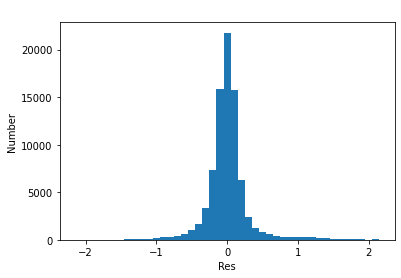

In [21]:
import pylab as pl
def draw_hist(lenths):  #lenths 接受的其实是 sizeArry传来的数组 就是def get_data(lines) 返回的数据
    data = lenths 

# 对数据进行切片，将数据按照从最小值到最大值分组，分成20组
    bins = [-2.15,-2.05,-1.95,-1.85,-1.75,-1.65,-1.55,-1.45,-1.35,-1.25,-1.15,-1.05,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,1.05,1.15,1.25,1.35,1.45, 1.55,1.65,1.75,1.85,1.95,2.05,2.15]

# 这个是调用画直方图的函数，意思是把数据按照从bins的分割来画
    pl.hist(data,bins)
#设置出横坐标
    pl.xlabel('Res')
#设置纵坐标的标题
    pl.ylabel('Number')
#设置整个图片的标题
    pl.title(' ')

# 展示出我们的图片
    pl.show()
    
draw_hist(res)

In [22]:
testY2 = Y_test.T
pred2 = pred.T
print(testY2.shape)
print(pred2.shape)

(1, 83186)
(1, 83186)


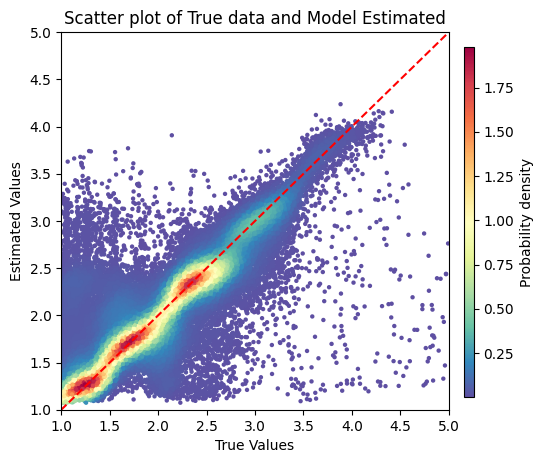

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

x2 = np.linspace(-10,10)
y2=x2
x=testY2#第一维数据
y=pred2#第二维数据
xy = np.vstack([x,y])#将两个维度的数据进行叠加
kenal = gaussian_kde(xy)#这一步根据xy这个样本数据，在全定义域上建立了概率密度分布，所以kenal其实就是一个概率密度函数，输入对应的(x,y)坐标，就给出相应的概率密度
z = kenal.evaluate(xy)#得到我们每个样本点的概率密度
z = gaussian_kde(xy)(xy)#这行代码和上面两行是相同的意思，这行是一行的写法
idx = z.argsort() #对z值进行从小到大排序并返回索引
# x, y, z = x[idx], y[idx], z[idx]#对x,y按照z的升序进行排列
#上面两行代码是为了使得z值越高的点，画在上面，不被那些z值低的点挡住，从美观的角度来说还是十分必要的
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
scatter = ax.scatter(x,y,marker='o',c=z,edgecolors='none',s=10,label='label'
                     ,cmap='Spectral_r')
cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])#[left,bottom,width,height] position
cbar = fig.colorbar(scatter, cax=cbar_ax, label='Probability density')
ax.set_xlabel('True Values')
ax.set_ylabel('Estimated Values')
ax.set_title('Scatter plot of True data and Model Estimated')
ax.set_xlim((1, 5.0))
ax.set_ylim((1, 5.0))
ax.plot(x2,y2,color='r' ,linewidth=1.5,linestyle='--')

#plt.savefig('pred140-copy1_2.jpg')

# -------------------------end-----------------------------